# Q1 - PCA

## Import the libraries

In [1]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

## (A) Load the Data

In [2]:
def data_and_headers(filename):
    data = None
    with open(filename) as fp:
        data = [x.strip().split(',') for x in fp.readlines()]
    headers = data[0]
    headers = np.asarray(headers)
    class_field = len(headers) - 1
    data_x = [[float(x[i]) for i in range(class_field)] for x in data[1:]]
    data_x = np.asarray(data_x)
    data_y = [[str(x[i]) for i in range(class_field, class_field + 1)] for x in data[1:]]
    data_y = np.asarray(data_y)
    return headers, data_x, data_y

In [3]:
headers, train_x, train_y = data_and_headers('Data' + os.sep + 'hw2q1_train.csv')
headers, test_x, test_y = data_and_headers('Data' + os.sep + 'hw2q1_test.csv')

In [4]:
print('Training Data')
print('Number of features - ' + str(train_x.shape[1]))
print('Number of target features - ' + str(train_y.shape[1]))
print('Number of observations - ' + str(train_x.shape[0]))
print('Number of observations in category R - ' + str(train_y[train_y=='R'].shape[0]))
print('Number of observations in category M - ' + str(train_y[train_y=='M'].shape[0]))
print()
print('Testing Data')
print('Number of features - ' + str(test_x.shape[1]))
print('Number of target features - ' + str(test_y.shape[1]))
print('Number of observations - ' + str(test_x.shape[0]))
print('Number of observations in category R - ' + str(test_y[test_y=='R'].shape[0]))
print('Number of observations in category M - ' + str(test_y[test_y=='M'].shape[0]))

Training Data
Number of features - 60
Number of target features - 1
Number of observations - 156
Number of observations in category R - 73
Number of observations in category M - 83

Testing Data
Number of features - 60
Number of target features - 1
Number of observations - 52
Number of observations in category R - 24
Number of observations in category M - 28


## (B) Normalization and PCA

In [5]:
def normalize(data, minima, maxima):
    normal = np.copy(data)
    normal = (normal - minima) / (maxima - minima)
    return normal

In [6]:
normal_train = normalize(train_x, np.amin(train_x, axis=0), np.amax(train_x, axis=0))
normal_test = normalize(test_x, np.amin(train_x, axis=0), np.amax(train_x, axis=0))

### (i) Covariance of Training Dataset

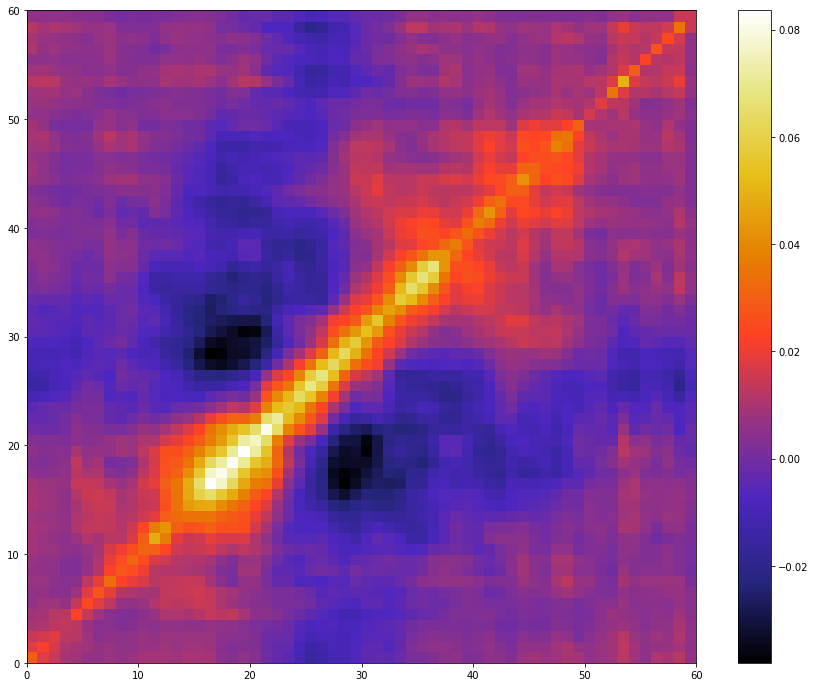

In [7]:
covariance = np.cov(normal_train, rowvar=False)
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(15)
im = axes.pcolor(covariance, cmap='CMRmap')
fig.colorbar(im, ax=axes)
plt.show()

### (ii) Eigenvalue and Eigenvectors

In [8]:
print('Size of covariance matrix - ' + str(covariance.shape))
w,v = np.linalg.eig(covariance)
print('Top 5 Eigenvalues - ' + ', '.join(['{:.3f}'.format(x) for x in w[:5]]))

Size of covariance matrix - (60, 60)
Top 5 Eigenvalues - 0.695, 0.457, 0.223, 0.191, 0.118


### (iii) Plot of Eigenvalues

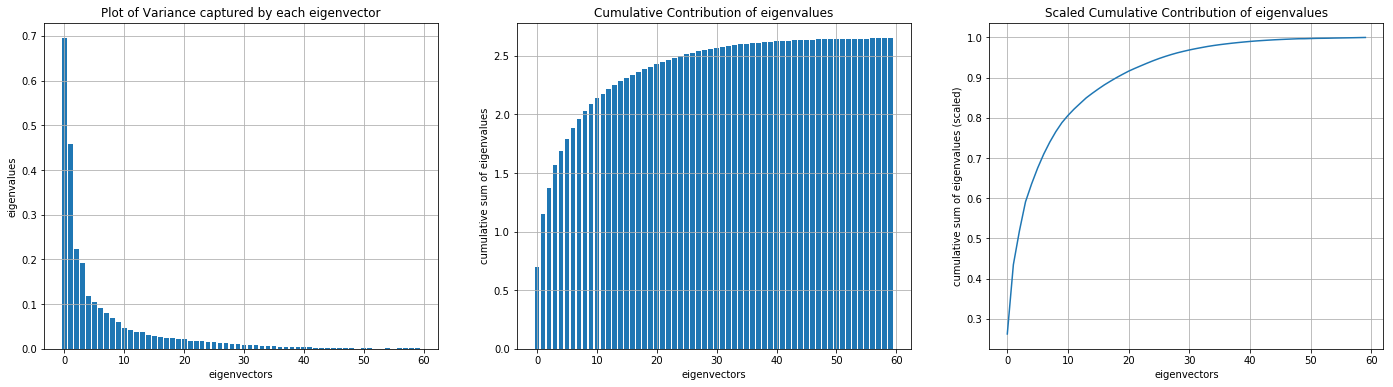

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(6)
fig.set_figwidth(24)
axes[0].bar(np.arange(60), w)
axes[0].xaxis.grid()
axes[0].yaxis.grid()
axes[0].set_xlabel('eigenvectors')
axes[0].set_ylabel('eigenvalues')
axes[0].set_title('Plot of Variance captured by each eigenvector')
axes[1].bar(np.arange(60), np.cumsum(w))
axes[1].xaxis.grid()
axes[1].yaxis.grid()
axes[1].set_xlabel('eigenvectors')
axes[1].set_ylabel('cumulative sum of eigenvalues')
axes[1].set_title('Cumulative Contribution of eigenvalues')
axes[2].plot(np.arange(60), np.cumsum(w)/np.sum(w))
axes[2].xaxis.grid()
axes[2].yaxis.grid()
axes[2].set_xlabel('eigenvectors')
axes[2].set_ylabel('cumulative sum of eigenvalues (scaled)')
axes[2].set_title('Scaled Cumulative Contribution of eigenvalues')
plt.show()

### Number of Eigenvectors - 10
***This is because if we look at the scaled cumulative contribution of the eigen values, we can see that the first 10 eigenvalues cover almost 80% of all variance in the data set. So 10 seems to be a good choice for selecting the number of eigenvectors.***

### (iv) PCA with KNN

In [10]:
ncomps = [2,4,6,8,10,20,40,60]
cls = [KNeighborsClassifier(n_neighbors=3, metric='euclidean').fit(np.matmul(normal_train, v[:,:ncomps[i]]), np.ravel(train_y)) for i in range(len(ncomps))]

In [11]:
pred4 = cls[4].predict(np.matmul(normal_test, v[:,:ncomps[4]]))
true4 = np.ravel(test_y)
with open('q1iv.csv','w') as fp:
    fp.write(', '.join(['Component' + str(i) for i in range(1,ncomps[4]+1)])+', Class, Class\n')
    transformed = np.matmul(normal_test, v[:,:ncomps[4]])
    for i in range(len(transformed)):
        fp.write(', '.join([str(x) for x in transformed[i]]))
        fp.write(', ' + str(true4[i]))
        fp.write(', ' + str(pred4[i]) + '\n')

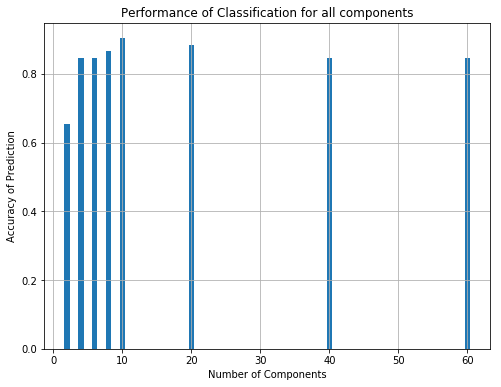

Accuracy - 
Components	Accuracy
2		65.3846%
4		84.6154%
6		84.6154%
8		86.5385%
10		90.3846%
20		88.4615%
40		84.6154%
60		84.6154%


In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(6)
fig.set_figwidth(8)
accuracies = [cls[i].score(np.matmul(normal_test, v[:,:ncomps[i]]), np.ravel(test_y)) for i in range(len(ncomps))]
axes.bar(ncomps, accuracies)
axes.set_xlabel('Number of Components')
axes.set_ylabel('Accuracy of Prediction')
axes.set_title('Performance of Classification for all components')
plt.grid()
plt.show()
print('Accuracy - ')
print('Components\tAccuracy')
for i in range(len(ncomps)):
    print('{}\t\t{:.4f}%'.format(ncomps[i],100*accuracies[i]))

### Reasonable Number of PCA components - 10
***The reasons are 2-fold - 1) We predicted it above when we plotted the eigenvalues and 2) It gives the best accuracy out of the given number of components.***

## (C) Standardization and PCA

In [13]:
def standardize(data, mean, sd):
    standard = np.copy(data)
    standard = (standard - mean) / sd
    return standard

In [14]:
standard_train = standardize(train_x, np.mean(train_x, axis=0), np.std(train_x, axis=0))
standard_test = standardize(test_x, np.mean(train_x, axis=0), np.std(train_x, axis=0))

### (i) Covariance of Training Dataset

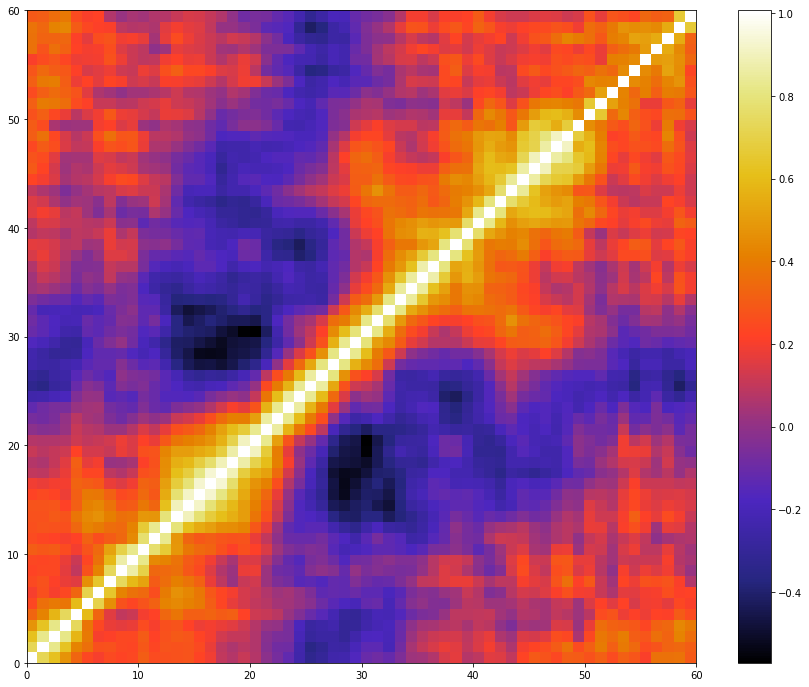

In [15]:
covariance = np.cov(standard_train, rowvar=False)
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(15)
im = axes.pcolor(covariance, cmap='CMRmap')
fig.colorbar(im, ax=axes)
plt.show()

### (ii) Eigenvalue and Eigenvectors

In [16]:
print('Size of covariance matrix - ' + str(covariance.shape))
w,v = np.linalg.eig(covariance)
print('Top 5 Eigenvalues - ' + ', '.join(['{:.3f}'.format(x) for x in w[:5]]))

Size of covariance matrix - (60, 60)
Top 5 Eigenvalues - 12.429, 11.558, 4.979, 3.345, 3.226


### (iii) Plot of Eigenvalues

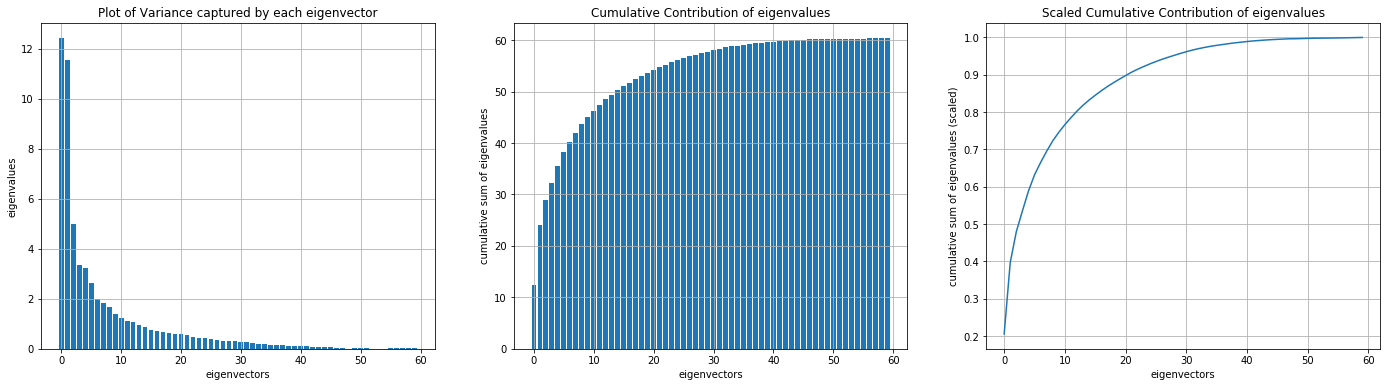

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(6)
fig.set_figwidth(24)
axes[0].bar(np.arange(60), w)
axes[0].xaxis.grid()
axes[0].yaxis.grid()
axes[0].set_xlabel('eigenvectors')
axes[0].set_ylabel('eigenvalues')
axes[0].set_title('Plot of Variance captured by each eigenvector')
axes[1].bar(np.arange(60), np.cumsum(w))
axes[1].xaxis.grid()
axes[1].yaxis.grid()
axes[1].set_xlabel('eigenvectors')
axes[1].set_ylabel('cumulative sum of eigenvalues')
axes[1].set_title('Cumulative Contribution of eigenvalues')
axes[2].plot(np.arange(60), np.cumsum(w)/np.sum(w))
axes[2].xaxis.grid()
axes[2].yaxis.grid()
axes[2].set_xlabel('eigenvectors')
axes[2].set_ylabel('cumulative sum of eigenvalues (scaled)')
axes[2].set_title('Scaled Cumulative Contribution of eigenvalues')
plt.show()

### (iv) PCA with KNN

In [18]:
ncomps = [2,4,6,8,10,20,40,60]
cls = [KNeighborsClassifier(n_neighbors=3, metric='euclidean').fit(np.matmul(standard_train, v[:,:ncomps[i]]), np.ravel(train_y)) for i in range(len(ncomps))]

In [19]:
pred4 = cls[4].predict(np.matmul(standard_test, v[:,:ncomps[4]]))
true4 = np.ravel(test_y)
with open('q1v.csv','w') as fp:
    fp.write(', '.join(['Component' + str(i) for i in range(1,ncomps[4]+1)])+', Class, Class\n')
    transformed = np.matmul(standard_test, v[:,:ncomps[4]])
    for i in range(len(transformed)):
        fp.write(', '.join([str(x) for x in transformed[i]]))
        fp.write(', ' + str(true4[i]))
        fp.write(', ' + str(pred4[i]) + '\n')

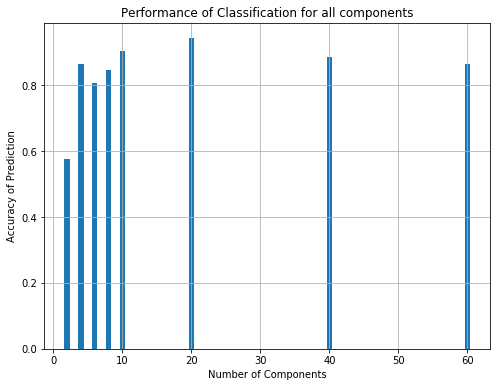

Accuracy - 
Components	Accuracy
2		57.6923%
4		86.5385%
6		80.7692%
8		84.6154%
10		90.3846%
20		94.2308%
40		88.4615%
60		86.5385%


In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(6)
fig.set_figwidth(8)
accuracies = [cls[i].score(np.matmul(standard_test, v[:,:ncomps[i]]), np.ravel(test_y)) for i in range(len(ncomps))]
axes.bar(ncomps, accuracies)
axes.set_xlabel('Number of Components')
axes.set_ylabel('Accuracy of Prediction')
axes.set_title('Performance of Classification for all components')
plt.grid()
plt.show()
print('Accuracy - ')
print('Components\tAccuracy')
for i in range(len(ncomps)):
    print('{}\t\t{:.4f}%'.format(ncomps[i],100*accuracies[i]))

## (D) Preference

In [ ]:
Compring both 